
This script generates hillslope mesh with a varying organic layer thickness at the top.

In [1]:
%matplotlib inline

In [2]:
# global parameters
dx = 10
outlet_elevation = 0

# run-specific parameters

# -- hillslope geometry
hillslope_length = 800
hillslope_slope = 0.1
toeslope_length = 200
toeslope_slope = 0.01

hillslope_acrotelm = 0.1
hillslope_catotelm = 0.12
toeslope_acrotelm = 0.12
toeslope_catotelm = 0.2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import logging

import workflow.mesh
import workflow.ui

workflow.ui.setup_logging(1,None)



/Users/uec/code/watershed-workflow/repos/master/workflow/mesh.py:410: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert(len(c) is 3) # check all triangles
/Users/uec/code/watershed-workflow/repos/master/workflow/mesh.py:479: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


In [4]:
# global derived parameters
n_hillslope = int(round(hillslope_length / dx))
n_toeslope = int(round(toeslope_length/dx))
n_total = n_hillslope + n_toeslope

hillslope_length = n_hillslope * dx
toeslope_length = n_toeslope * dx
total_length = hillslope_length + toeslope_length



# of cells: 100


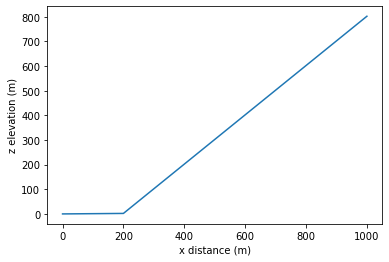

In [5]:
xs = np.linspace(0,total_length,n_total+1)

def z_of_x(x):
    z = outlet_elevation
    z += min(x, toeslope_length) * toeslope_slope
    z += max(0, min(x - toeslope_length, hillslope_length))
    return z
        
zs = np.array([z_of_x(x) for x in xs])

plt.plot(xs,zs); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = workflow.mesh.Mesh2D.from_Transect(xs,zs)
print('# of cells:', m2.num_cells())

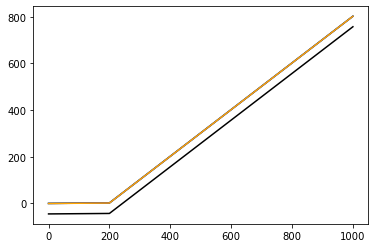

In [6]:
# Changing organic layer thickness 
acrotelm_thickness = np.where(xs < toeslope_length, toeslope_acrotelm, hillslope_acrotelm)
catotelm_thickness = np.where(xs < toeslope_length, toeslope_catotelm, hillslope_catotelm)

plt.plot(xs, zs, 'g')
plt.plot(xs, zs - acrotelm_thickness, 'b')
plt.plot(xs, zs - acrotelm_thickness - catotelm_thickness, 'orange')
plt.plot(xs, zs - 45, 'k')
plt.show()

In [18]:
# preparing layer extrusion data for meshing_ats
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical unit to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth = []  # used later to get the mat ids right, just for bookkeeping
   
    
z = 0.0
dz = 0.02


assert((acrotelm_thickness + catotelm_thickness).max() < 1)
# here we will only use 1 cell per layer, so layer thickness = dz.
# top meter at 2cm cells
# 
# must do them as independent layers to get the layering of acrotelm/catotelm/mineral correct

for i in range(50):
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    z += dz
    layer_depth.append(z)
    layer_mat_ids.append(np.where(z - 0.01 > acrotelm_thickness + catotelm_thickness, 101,
                                  np.where(z - 0.01 > acrotelm_thickness, 102, 103)))

# now go from 1m down to 10m telescoping
ncells = 18
tele = workflow.mesh.telescope_factor(ncells, dz, 7)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(101 * np.ones((m2.num_cells()+1,),dtype='i'))
    z += dz
    dz *= tele
    
# now go from 10m to 46m in 2m cells
layer_types.append('constant')
layer_data.append(36)
layer_ncells.append(18)
layer_mat_ids.append(101 * np.ones((m2.num_cells()+1,),'i'))

print([lm.shape for lm in layer_mat_ids])

# print out the result
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

2020-08-17 14:43:44,073 - root - INFO: Converged?: ratio = 1.2943928503623967, layer z (target = 7) = 3.9465319900955365e-11
2020-08-17 14:43:44,075 - root - INFO: Got telescoping factor: 1.2943928503623967
2020-08-17 14:43:44,077 - root - INFO: Cell summary:
2020-08-17 14:43:44,078 - root - INFO: ------------------------------------------------------------
2020-08-17 14:43:44,079 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-08-17 14:43:44,080 - root - INFO: ------------------------------------------------------------
2020-08-17 14:43:44,080 - root - INFO:  00 	| 00 	|  103 	|   0.020000 	|   0.000000
2020-08-17 14:43:44,081 - root - INFO:  01 	| 01 	|  103 	|   0.020000 	|   0.020000
2020-08-17 14:43:44,082 - root - INFO:  02 	| 02 	|  103 	|   0.020000 	|   0.040000
2020-08-17 14:43:44,083 - root - INFO:  03 	| 03 	|  103 	|   0.020000 	|   0.060000
2020-08-17 14:43:44,083 - root - INFO:  04 	| 04 	|  103 	|   0.020000 	|   0.080000
2020-08-17 14:43:44,084 - root - INFO:  05

[(101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,), (101,)]


In [19]:
# make the mesh, save it as an exodus file
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types,layer_data, layer_ncells, np.array(layer_mat_ids))
m3.write_exodus("sample_hillslope.exo")


You are using exodus.py v 1.19.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: sample_hillslope.exo
Closing exodus file: sample_hillslope.exo


In [22]:
# Make a column that is the same as the hillslope for use in spinup.
# 1 km long hillslope, 10% slope
xc = np.array([0,1])
zc = np.array([0,0])
m2c = workflow.mesh.Mesh2D.from_Transect(xc,zc)

In [23]:
column_mat_ids = [lmi[0] for lmi in layer_mat_ids]

In [25]:
m3c = workflow.mesh.Mesh3D.extruded_Mesh2D(m2c, layer_types,layer_data, layer_ncells, column_mat_ids)
m3c.write_exodus("sample_column.exo")

Opening exodus file: sample_column.exo
Closing exodus file: sample_column.exo
